# Argriculture Price and Profitability Analysis

In [1]:
# Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

import plotly
import cufflinks as cf
cf.go_offline()

In [2]:
# Pull in and view dataset
prod_price_df = pd.read_csv('Data/ProductPriceIndex.csv')
prod_price_df.head()

,productname,date,farmprice,atlantaretail,chicagoretail,losangelesretail,newyorkretail,averagespread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


In [3]:
# See more info on size and datatypes
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   productname       15766 non-null  object
 1   date              15766 non-null  object
 2   farmprice         15766 non-null  object
 3   atlantaretail     15766 non-null  object
 4   chicagoretail     15766 non-null  object
 5   losangelesretail  15766 non-null  object
 6   newyorkretail     15766 non-null  object
 7   averagespread     15766 non-null  object
dtypes: object(8)
memory usage: 985.5+ KB


In [4]:
# Clean up column names
prod_price_df = prod_price_df.rename(columns={'productname':'product_name',
                                      'farmprice':'farm_price',
                                      'atlantaretail':'atl_price',
                                      'chicagoretail':'chi_price',
                                      'losangelesretail':'la_price',
                                      'newyorkretail':'ny_price',
                                      'averagespread':'avg_spread'})
prod_price_df.head()

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread
0,Strawberries,2019-05-19,$1.16,$2.23,$1.70,$1.99,$2.54,82.33%
1,Romaine Lettuce,2019-05-19,$0.35,$1.72,$2.00,$1.69,$1.99,428.57%
2,Red Leaf Lettuce,2019-05-19,$0.32,$1.84,$1.84,$1.69,$1.89,467.19%
3,Potatoes,2019-05-19,$1.50,$5.32,$5.14,$3.99,$6.22,244.50%
4,Oranges,2019-05-19,$0.41,$1.42,$1.45,$1.34,$2.05,281.71%


In [5]:
# UPDATE DATA TYPES

# 'date'
prod_price_df['date'] = pd.to_datetime(prod_price_df['date'], yearfirst=True)

In [6]:
# prices (convert values of '$' to NaN)
price_cols = ['farm_price', 'atl_price', 'chi_price','la_price', 'ny_price']

for col in price_cols:
    str_float = prod_price_df[col].str.split('$', expand=True)[1]
    str_float[str_float == ''] = np.nan
    prod_price_df[col] = str_float.astype(float)

In [7]:
# Change 'avg_spread' from percent to decimal

str_percent = prod_price_df['avg_spread'].str.split('%', expand=True)[0]
str_percent = str_percent.str.replace(',', '')
prod_price_df['avg_spread'] = str_percent.astype(float)

In [8]:
# View Dtypes to confirm columns are correct types
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15766 entries, 0 to 15765
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  15766 non-null  object        
 1   date          15766 non-null  datetime64[ns]
 2   farm_price    15765 non-null  float64       
 3   atl_price     15765 non-null  float64       
 4   chi_price     15766 non-null  float64       
 5   la_price      15766 non-null  float64       
 6   ny_price      15758 non-null  float64       
 7   avg_spread    15766 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 985.5+ KB


In [9]:
# View all rows with NaN values
prod_price_df[prod_price_df.isna().any(axis=1)]

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread
107,Romaine Lettuce,2019-03-24,0.34,1.99,2.12,1.69,NaN,326.47
234,Red Leaf Lettuce,2019-01-13,0.66,2.32,1.98,1.74,NaN,128.79
262,Iceberg Lettuce,2018-12-30,0.47,1.29,1.54,1.67,NaN,139.36
315,Thompson Grapes,2018-12-02,0.85,2.31,1.64,2.12,NaN,78.53
331,Strawberries,2018-11-25,2.69,3.36,3.84,3.99,NaN,4.00
466,Romaine Lettuce,2018-09-23,0.44,1.59,1.99,1.42,NaN,184.09
690,Red Leaf Lettuce,2018-07-01,0.31,1.62,1.71,1.42,NaN,283.06
1261,Broccoli Crowns,2017-09-24,1.71,2.10,1.32,1.94,NaN,-21.64
2469,Celery,2016-02-28,0.53,NaN,1.92,1.99,1.72,165.57
2590,Oranges,2015-12-20,NaN,1.89,1.27,0.99,1.65,0.00


In [10]:
# Drop all 10 rows with NaN values and reset index
prod_price_df = prod_price_df.dropna().reset_index(drop=True)
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15756 entries, 0 to 15755
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   product_name  15756 non-null  object        
 1   date          15756 non-null  datetime64[ns]
 2   farm_price    15756 non-null  float64       
 3   atl_price     15756 non-null  float64       
 4   chi_price     15756 non-null  float64       
 5   la_price      15756 non-null  float64       
 6   ny_price      15756 non-null  float64       
 7   avg_spread    15756 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 984.9+ KB


In [11]:
# Add a margin column for each city
cities = ['atl', 'chi', 'la', 'ny']

for city in cities:
    prod_price_df[f'{city}_spread'] = ((prod_price_df[f'{city}_price'] - prod_price_df['farm_price']) / prod_price_df['farm_price']) * 100

prod_price_df.head()

,product_name,date,farm_price,atl_price,chi_price,la_price,ny_price,avg_spread,atl_spread,chi_spread,la_spread,ny_spread
0,Strawberries,2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33,92.241379,46.551724,71.551724,118.965517
1,Romaine Lettuce,2019-05-19,0.35,1.72,2.00,1.69,1.99,428.57,391.428571,471.428571,382.857143,468.571429
2,Red Leaf Lettuce,2019-05-19,0.32,1.84,1.84,1.69,1.89,467.19,475.000000,475.000000,428.125000,490.625000
3,Potatoes,2019-05-19,1.50,5.32,5.14,3.99,6.22,244.50,254.666667,242.666667,166.000000,314.666667
4,Oranges,2019-05-19,0.41,1.42,1.45,1.34,2.05,281.71,246.341463,253.658537,226.829268,400.000000


In [12]:
# Reorder columns and sort by date and product type to assist with plotting
ordered_cols = ['date','product_name','farm_price','atl_price','chi_price','la_price',
                'ny_price','atl_spread','chi_spread','la_spread','ny_spread','avg_spread']
prod_price_df = prod_price_df[ordered_cols] \
    .sort_values(by=['date', 'product_name'], ascending=True).reset_index(drop=True)

In [13]:
prod_price_df.head(30)

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
0,1999-10-24,Broccoli Bunches,0.23,1.21,0.0,0.84,1.10,426.086957,-100.0,265.217391,378.260870,242.39
1,1999-10-24,Broccoli Crowns,0.29,1.46,0.0,0.97,1.15,403.448276,-100.0,234.482759,296.551724,208.62
2,1999-10-24,Cantaloupe,0.21,0.54,0.0,0.56,0.79,157.142857,-100.0,166.666667,276.190476,125.00
3,1999-10-24,Carrots,0.12,0.64,0.0,0.84,0.59,433.333333,-100.0,600.000000,391.666667,331.25
4,1999-10-24,Cauliflower,0.19,1.01,0.0,0.75,0.92,431.578947,-100.0,294.736842,384.210526,252.63
5,1999-10-31,Broccoli Bunches,0.23,1.11,0.0,0.99,1.13,382.608696,-100.0,330.434783,391.304348,251.09
6,1999-10-31,Broccoli Crowns,0.29,1.34,0.0,1.12,1.26,362.068966,-100.0,286.206897,334.482759,220.69
7,1999-10-31,Cantaloupe,0.18,0.71,0.0,0.56,0.79,294.444444,-100.0,211.111111,338.888889,186.11
8,1999-10-31,Carrots,0.12,0.64,0.0,0.49,0.59,433.333333,-100.0,308.333333,391.666667,258.33
9,1999-10-31,Cauliflower,0.22,1.07,0.0,0.87,0.74,386.363636,-100.0,295.454545,236.363636,204.55


In [14]:
# Noticing lots of $0.00 retail prices so must investigate and determine if dropping those rows is appropriate

for city in cities:
    zero_df = prod_price_df[prod_price_df[f'{city}_price'] == 0.0]
    print(f'{city}_price contains {len(zero_df)} 0.0 values.')
    print(f'They range from {zero_df["date"].min()} to {zero_df["date"].max()}.')
    print('-'*20)


atl_price contains 193 0.0 values.
They range from 2001-03-25 00:00:00 to 2015-09-20 00:00:00.
--------------------
chi_price contains 1103 0.0 values.
They range from 1999-10-24 00:00:00 to 2014-08-17 00:00:00.
--------------------
la_price contains 84 0.0 values.
They range from 2001-10-21 00:00:00 to 2016-01-31 00:00:00.
--------------------
ny_price contains 332 0.0 values.
They range from 2000-04-09 00:00:00 to 2016-02-28 00:00:00.
--------------------


In [15]:
# A retail price of $0.00 is not accurate and may skew our analysis so we must drop those rows

for city in cities:
    prod_price_df = prod_price_df[prod_price_df[f'{city}_price'] != 0.0]
    len(prod_price_df[f'{city}_price'] == 0.0)
    
prod_price_df = prod_price_df.reset_index(drop=True)
prod_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14198 entries, 0 to 14197
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          14198 non-null  datetime64[ns]
 1   product_name  14198 non-null  object        
 2   farm_price    14198 non-null  float64       
 3   atl_price     14198 non-null  float64       
 4   chi_price     14198 non-null  float64       
 5   la_price      14198 non-null  float64       
 6   ny_price      14198 non-null  float64       
 7   atl_spread    14198 non-null  float64       
 8   chi_spread    14198 non-null  float64       
 9   la_spread     14198 non-null  float64       
 10  ny_spread     14198 non-null  float64       
 11  avg_spread    14198 non-null  float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 1.3+ MB


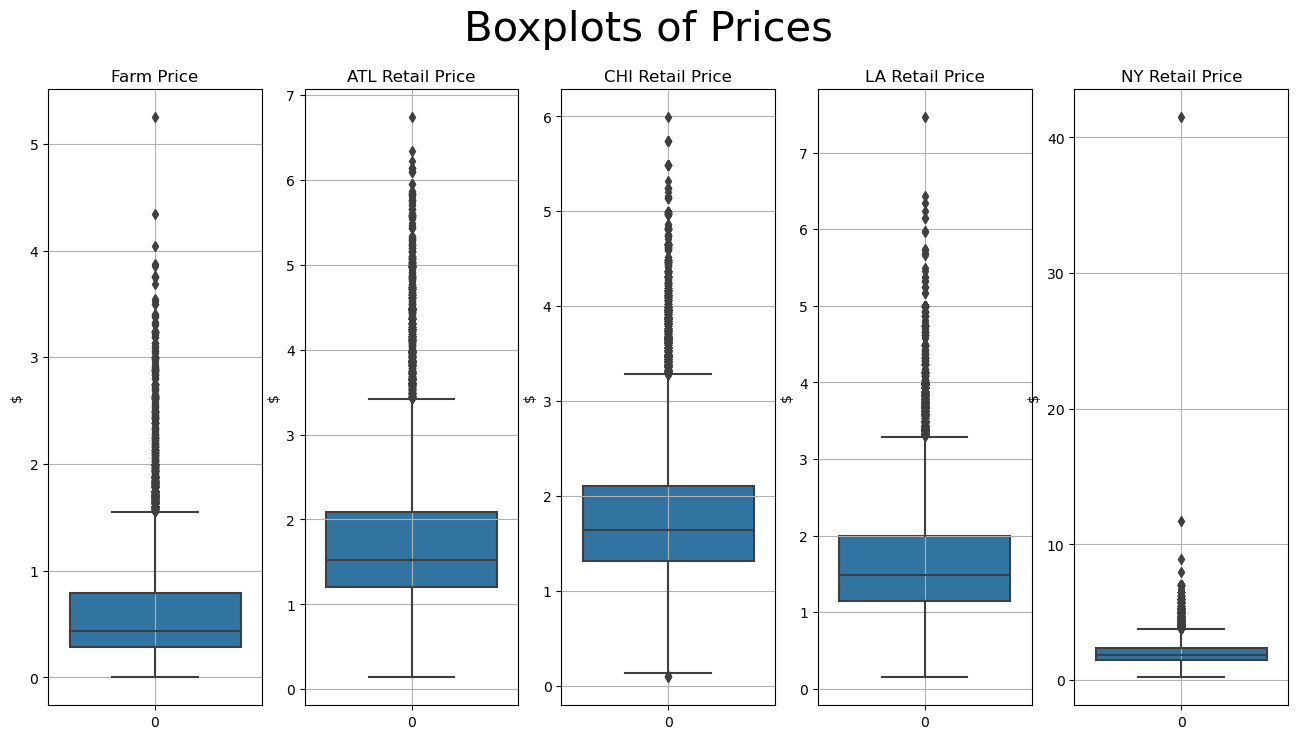

In [16]:
# Investigate outliers to see if they will skew our data and plots down the road

# box plots to visualize
fig, ax = plt.subplots(1, 5, sharey=False, figsize=(16,8))
fig.suptitle('Boxplots of Prices', fontsize=30)

sns.boxplot(prod_price_df['farm_price'],ax=ax[0])
ax[0].set_title('Farm Price')
ax[0].set_ylabel("$")
ax[0].grid()

for city in cities:
    axis=ax[cities.index(city)+1]
    sns.boxplot(prod_price_df[f'{city}_price'], ax=axis)
    axis.set_title(f'{city.upper()} Retail Price')
    axis.set_ylabel("$")
    axis.grid()

In [17]:
# Based on the above, there is only one concerning outlier in the 40s for 'ny_price' that we will remove
print(prod_price_df[prod_price_df['ny_price'] == prod_price_df['ny_price'].max()][['product_name', 'date', 'ny_price', 'atl_price', 'la_price', 'chi_price']])

drop_index = prod_price_df[prod_price_df['ny_price'] == prod_price_df['ny_price'].max()].index[0]

prod_price_df = prod_price_df.drop(drop_index).reset_index(drop=True)

          product_name       date  ny_price  atl_price  la_price  chi_price
2680  Red Leaf Lettuce 2004-06-20     41.49       1.09       0.8       1.27


In [18]:
# This is now our final cleaned dataset so we will rename it 'df' for ease of use
df = prod_price_df
df.head()

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
0,2001-02-04,Avocados,0.58,1.09,1.52,1.69,1.70,87.931034,162.068966,191.379310,193.103448,158.62
1,2001-02-04,Broccoli Bunches,0.25,1.23,1.19,1.07,1.14,392.000000,376.000000,328.000000,356.000000,363.00
2,2001-02-04,Broccoli Crowns,0.32,1.59,1.29,1.46,1.14,396.875000,303.125000,356.250000,256.250000,328.13
3,2001-02-04,Carrots,0.17,0.71,0.77,0.39,0.77,317.647059,352.941176,129.411765,352.941176,288.24
4,2001-02-04,Cauliflower,0.25,1.02,0.88,1.14,0.93,308.000000,252.000000,356.000000,272.000000,297.00


# Data Exploration

In [19]:
# View frequency of products in the dataset
print(f"Number of unique products in dataset: {df['product_name'].nunique()}")

df['product_name'].value_counts()

Number of unique products in dataset: 22


Cauliflower           947
Iceberg Lettuce       945
Green Leaf Lettuce    944
Celery                943
Red Leaf Lettuce      943
Romaine Lettuce       943
Broccoli Crowns       939
Carrots               939
Strawberries          915
Broccoli Bunches      902
Oranges               722
Avocados              654
Potatoes              612
Flame Grapes          473
Cantaloupe            466
Honeydews             426
Tomatoes              335
Thompson Grapes       262
Asparagus             235
Nectarines            229
Peaches               226
Plums                 197
Name: product_name, dtype: int64

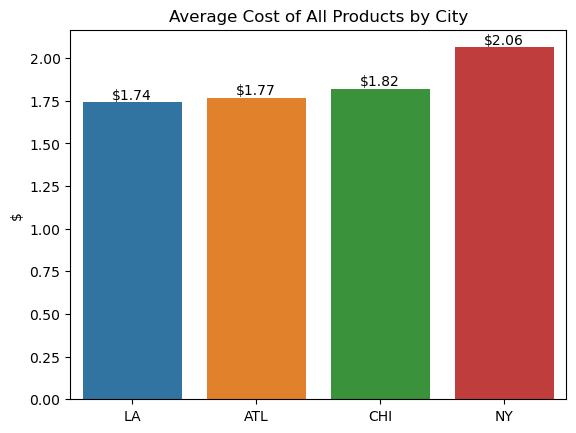

In [20]:
# Most expensive cities for consumers
city_price_avg = df[['atl_price', 'chi_price', 'la_price', 'ny_price']].mean().sort_values()

ax = sns.barplot(x=['LA','ATL','CHI', 'NY'], y=city_price_avg)
ax.bar_label(ax.containers[0], fmt='$%.2f')
plt.ylabel('$')
plt.title('Average Cost of All Products by City')
plt.show()

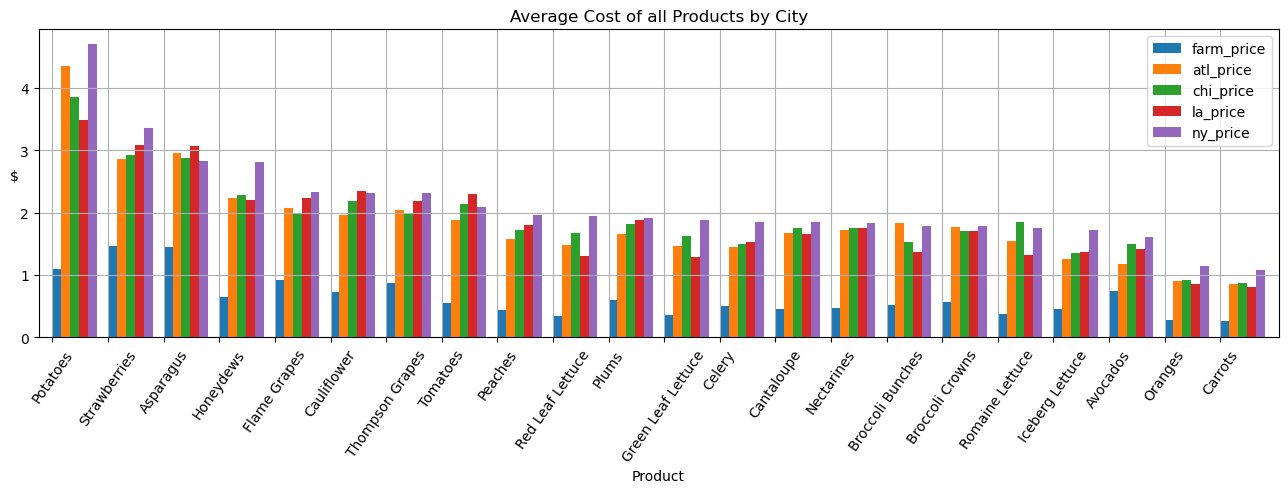

In [21]:
# Now let's see which product is most expensive for distributors and for consumers

product_groupby = df.groupby('product_name')
product_groupby.mean()[['farm_price','atl_price','chi_price','la_price','ny_price']] \
    .sort_values('ny_price', ascending=False).plot(kind='bar', figsize=(16,4), width=0.8, position=0)
plt.legend(loc='upper right')
plt.ylabel('$', rotation=0)
plt.grid()
plt.xlabel('Product')
plt.title('Average Cost of all Products by City')
plt.tick_params(axis='x', rotation=55)
plt.show()

In [22]:
# More interactive view with plotly
product_groupby.mean()[['farm_price','atl_price','chi_price','la_price','ny_price']] \
    .sort_values('ny_price', ascending=False).iplot(kind='bar')

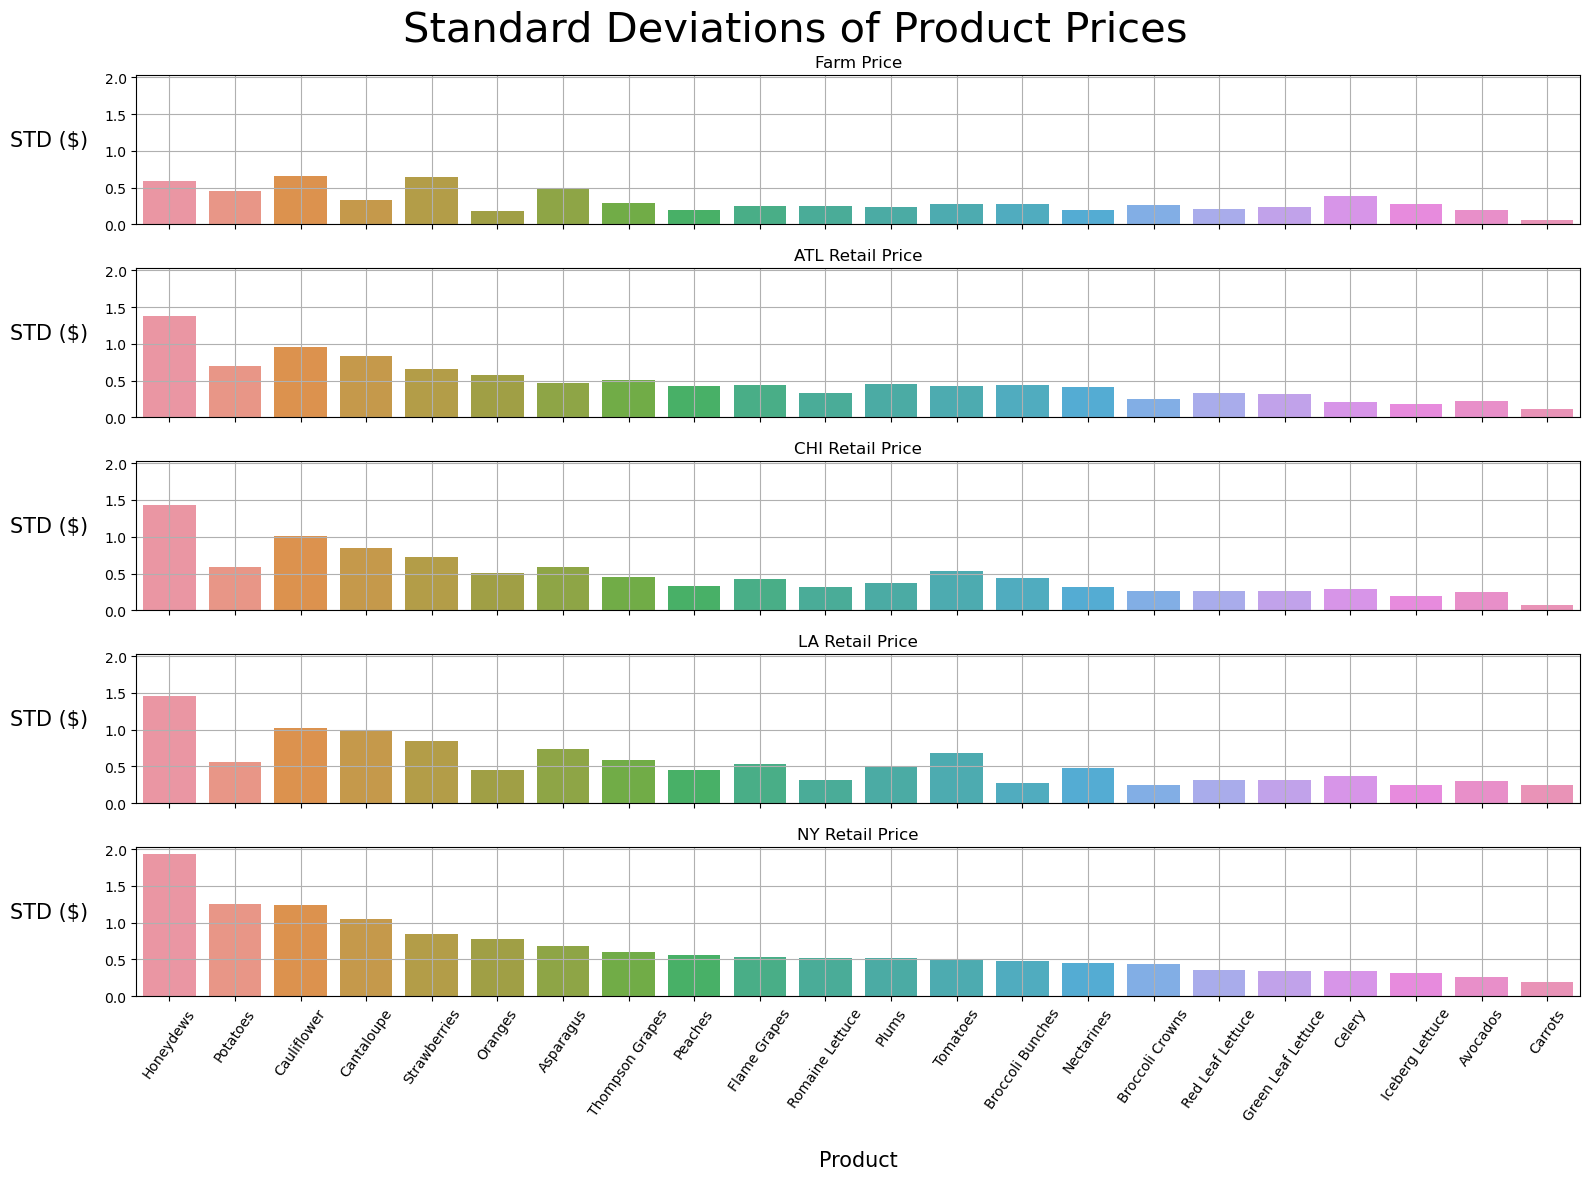

In [23]:
# Look at which products have the largest variation in price by looking at the standard deviation 

product_std = product_groupby.std().reset_index().sort_values('ny_price', ascending=False)

fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(16,12))
fig.suptitle('Standard Deviations of Product Prices', fontsize=30)

sns.barplot(ax=ax[0], x='product_name', y='farm_price', data=product_std)
ax[0].set_title('Farm Price')
ax[0].set_xlabel("")
ax[0].set_ylabel("STD ($)", rotation=0, labelpad=40, fontsize=15)
ax[0].grid()


for city in cities:
    axis=ax[cities.index(city)+1]
    sns.barplot(ax=axis,x='product_name', y=f'{city}_price', data=product_std)
    axis.set_title(f'{city.upper()} Retail Price')
    axis.set_xlabel("")
    axis.set_ylabel("STD ($)", rotation=0, labelpad=40, fontsize=15)
    axis.grid()
    axis.label_outer()


ax[4].set_xlabel("Product", labelpad=20, fontsize=15)
ax[4].tick_params(axis='x', rotation=55)
fig.tight_layout()

plt.show()

In [166]:
# Build a function that will generate timeseries of product prices and margins for each city over time


def gen_product_timeseries(product='Carrots', start_year=2015, end_year=2019, price=True):
    # Set string variable based on price bool variable
    if price:
        y_append = 'price'
        y_unit = '$'
        farm_replace = 'farm'
    else:
        y_append = 'spread'
        y_unit = '%'
        farm_replace = 'avg'
    
    # Create figure and axes for timeseries
    fig, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(16,12))
    fig.suptitle(f"{product} {y_append.capitalize()} ({y_unit}) from {start_year} to {end_year}", fontsize=30)
    
    # Create df for plot
    product_df = df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= end_year) & (df['product_name'] == product)]
    
    # Set color palette
    colors = sns.color_palette(n_colors=5)
    
    # Create the 'farm_price' plot at the to
        
    sns.lineplot(ax=ax[0], x='date', y=f'{farm_replace}_{y_append}', data=product_df, c=colors[0])
    ax[0].set_ylabel(f'{farm_replace.capitalize()} {y_append.capitalize()}', rotation=0, labelpad=50, fontsize=15)
    ax[0].tick_params(labelbottom=True)
    ax[0].grid()
    
    # Cities list
    cities = ['atl', 'chi', 'la', 'ny']

    for city in cities:
        axis=ax[cities.index(city)+1]
        sns.lineplot(ax=axis,x='date', y=f'{city}_{y_append}', data=product_df, c=colors[cities.index(city) + 1])
        axis.set_ylabel(f'{city.upper()} {y_append.capitalize()}', rotation=0, labelpad=50, fontsize=15)
        axis.tick_params(labelbottom=True)
        axis.grid()
    
    plt.show()

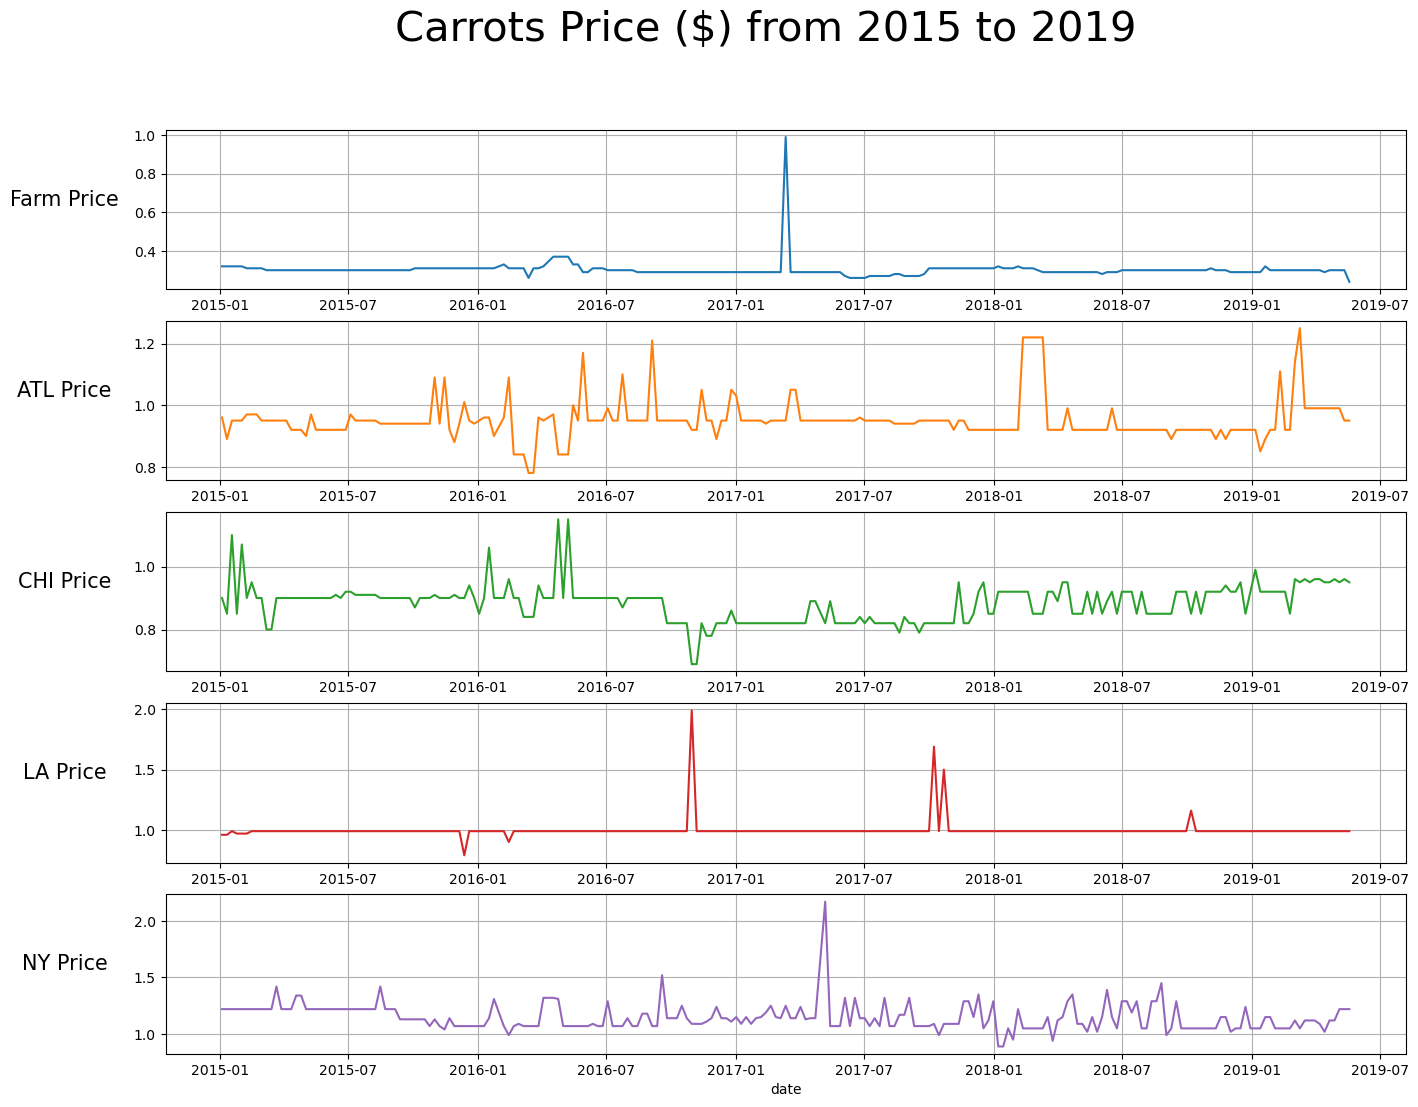

In [28]:
gen_product_timeseries()

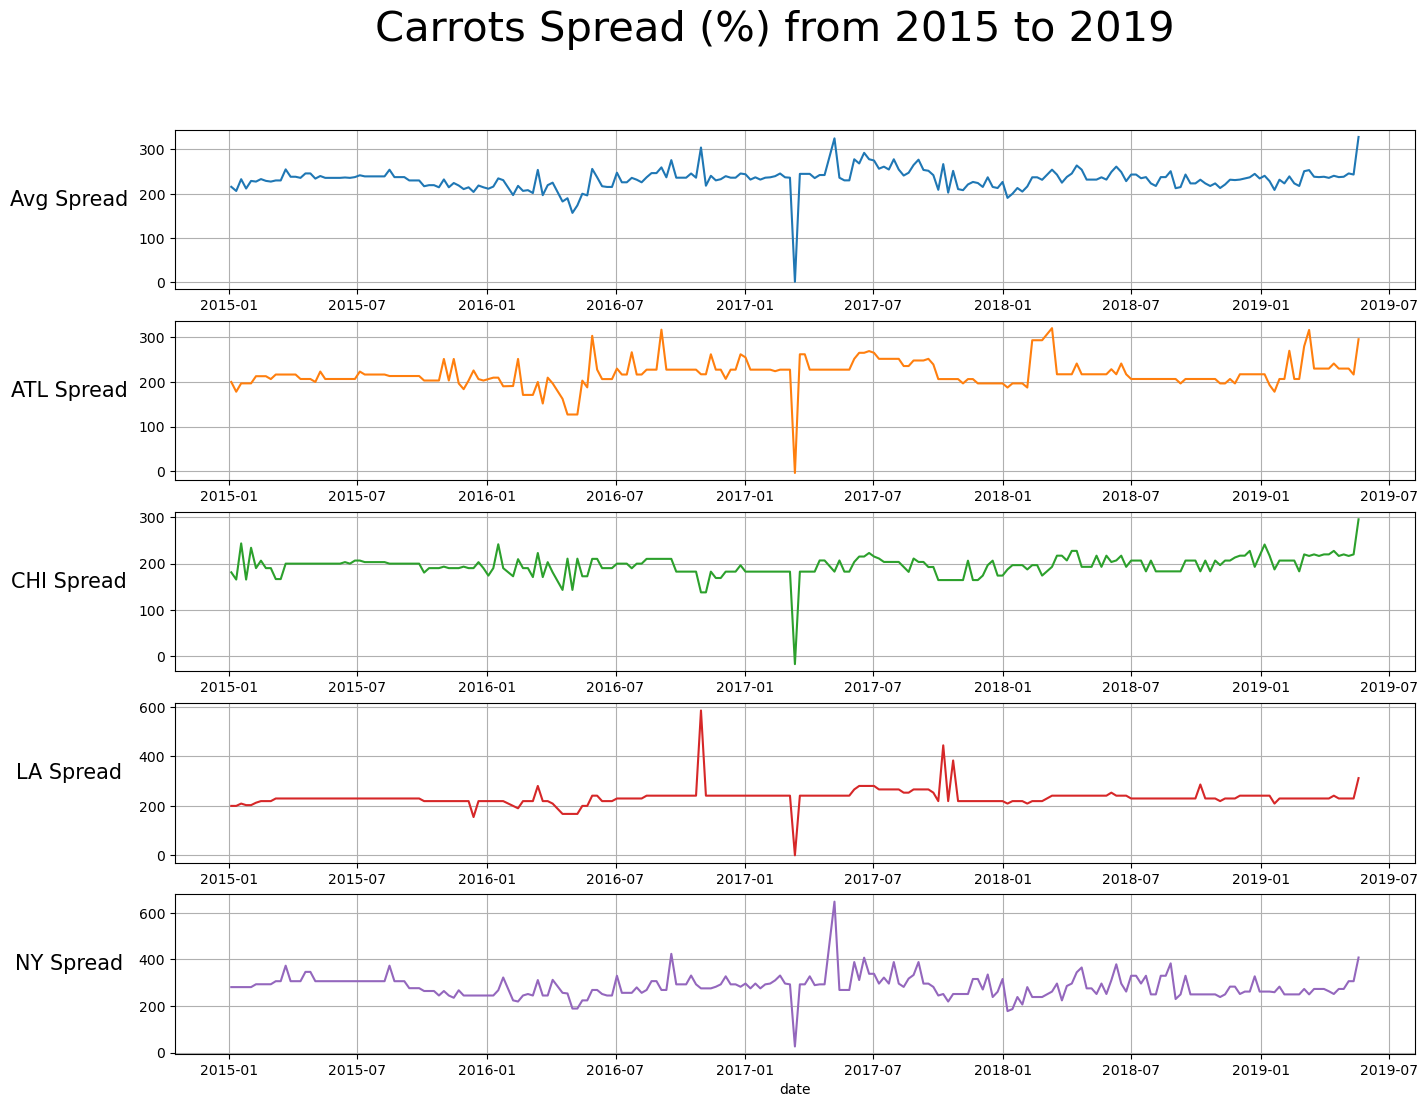

In [29]:
gen_product_timeseries(price=False)

In [ ]:
gen_product_timeseries(product='Honeydews')
gen_product_timeseries(product='Honeydews', price=False)

In [ ]:
gen_product_timeseries(product='Tomatoes', start_year=2000, end_year=2019)

In [30]:

df.head()


,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
0,2001-02-04,Avocados,0.58,1.09,1.52,1.69,1.70,87.931034,162.068966,191.379310,193.103448,158.62
1,2001-02-04,Broccoli Bunches,0.25,1.23,1.19,1.07,1.14,392.000000,376.000000,328.000000,356.000000,363.00
2,2001-02-04,Broccoli Crowns,0.32,1.59,1.29,1.46,1.14,396.875000,303.125000,356.250000,256.250000,328.13
3,2001-02-04,Carrots,0.17,0.71,0.77,0.39,0.77,317.647059,352.941176,129.411765,352.941176,288.24
4,2001-02-04,Cauliflower,0.25,1.02,0.88,1.14,0.93,308.000000,252.000000,356.000000,272.000000,297.00


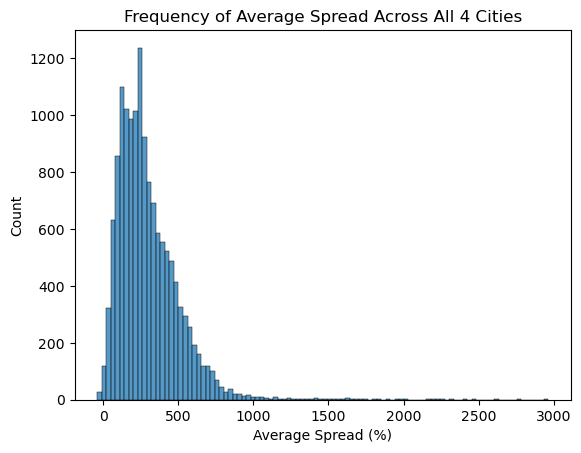

The mean of all average spread values across the four cities is: 300.0532950623361%


In [41]:
# MARGIN ANALYSIS
sns.histplot(df['avg_spread'], bins=100)
plt.title("Frequency of Average Spread Across All 4 Cities")
plt.xlabel("Average Spread (%)")
plt.show()
print(f"The mean of all average spread values across the four cities is: {df['avg_spread'].mean()}%")

In [82]:
# Long tail showing some very high avg_spreads...

top_500_spreads = df.sort_values('avg_spread', ascending=False).head(500)

top_500_spreads.head(25)

,date,product_name,farm_price,atl_price,chi_price,la_price,ny_price,atl_spread,chi_spread,la_spread,ny_spread,avg_spread
7729,2010-09-19,Honeydews,0.11,3.19,3.82,2.48,3.99,2800.000000,3372.727273,2154.545455,3527.272727,2963.64
3097,2004-12-19,Strawberries,0.18,4.65,5.49,4.49,5.99,2483.333333,2950.000000,2394.444444,3227.777778,2763.89
7713,2010-09-12,Honeydews,0.13,3.07,3.57,3.45,3.99,2261.538462,2646.153846,2553.846154,2969.230769,2607.69
7646,2010-08-15,Honeydews,0.13,4.05,3.57,2.95,3.49,3015.384615,2646.153846,2169.230769,2584.615385,2603.85
8399,2011-08-21,Cantaloupe,0.09,2.37,2.33,2.29,2.25,2533.333333,2488.888889,2444.444444,2400.000000,2466.67
7697,2010-09-05,Honeydews,0.13,3.19,3.09,3.13,3.62,2353.846154,2276.923077,2307.692308,2684.615385,2405.77
8383,2011-08-14,Cantaloupe,0.10,2.37,2.31,2.97,2.00,2270.000000,2210.000000,2870.000000,1900.000000,2312.50
7640,2010-08-15,Cantaloupe,0.09,1.94,2.76,2.25,1.50,2055.555556,2966.666667,2400.000000,1566.666667,2247.22
7746,2010-09-26,Honeydews,0.12,1.57,3.57,1.86,4.24,1208.333333,2875.000000,1450.000000,3433.333333,2241.67
7679,2010-08-29,Honeydews,0.13,1.99,3.57,2.95,3.49,1430.769231,2646.153846,2169.230769,2584.615385,2207.69


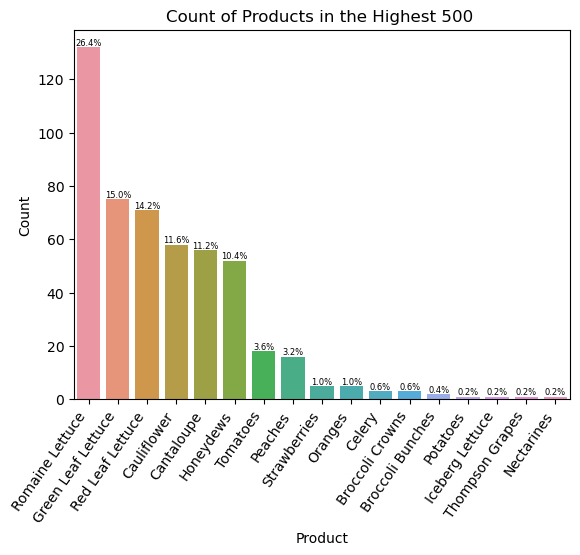

In [126]:
top_500_spreads_prod_dist = top_500_spreads.groupby('product_name').size().sort_values(ascending=False)

ax = sns.barplot(x=top_500_spreads_prod_dist.index, y=top_500_spreads_prod_dist)
ax.bar_label(ax.containers[0], labels= [f"{x/5}%" for x in top_500_spreads_prod_dist], fontsize=6)
plt.ylabel('Count')
plt.xlabel('Product')
plt.title('Count of Products in the Highest 500 ')
ax.set_xticklabels(top_500_spreads_prod_dist.index, rotation=55, ha='right')
plt.show()


In [147]:
# Lettuces are the most frequent but which generated the highest average
top_500_spreads_avg = top_500_spreads.groupby('product_name').mean()['avg_spread'].sort_values(ascending=False)
top_500_spreads_avg = top_500_spreads_avg.rename('Top 500 Avg Spread')

In [146]:
df_spreads_avg = df.groupby('product_name').mean()['avg_spread'].sort_values(ascending=False)
df_spreads_avg = df_spreads_avg.rename('Total Avg Spread')

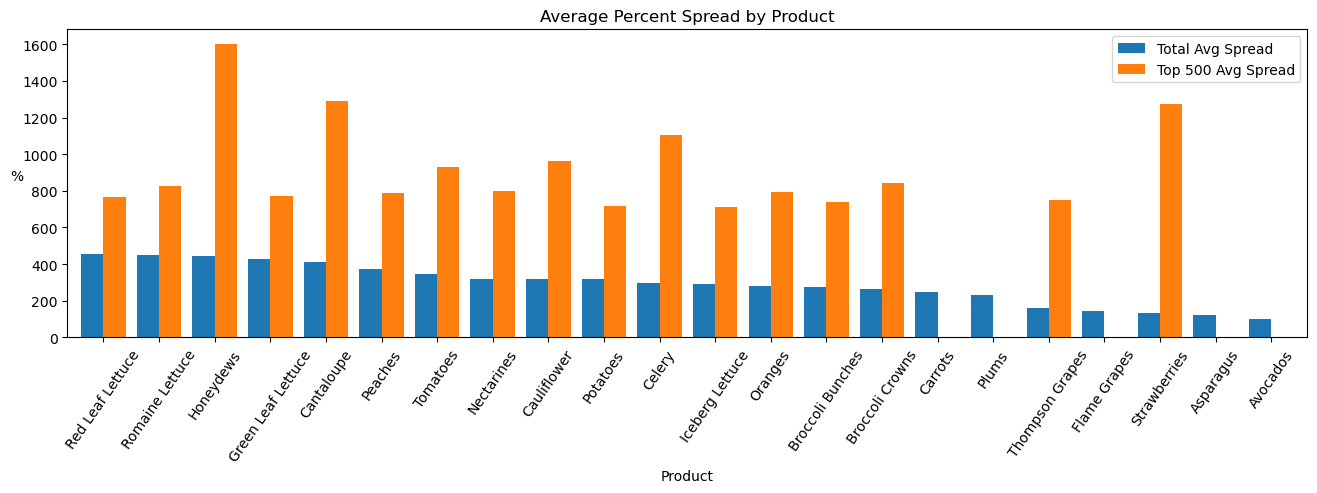

In [160]:
pd.concat([df_spreads_avg, top_500_spreads_avg], axis=1).plot(kind='bar', figsize=(16,4), width=.8)
plt.legend(loc='upper right')
plt.ylabel('%', rotation=0)
plt.xlabel('Product')
plt.title('Average Percent Spread by Product')
plt.tick_params(axis='x', rotation=55)
plt.show()

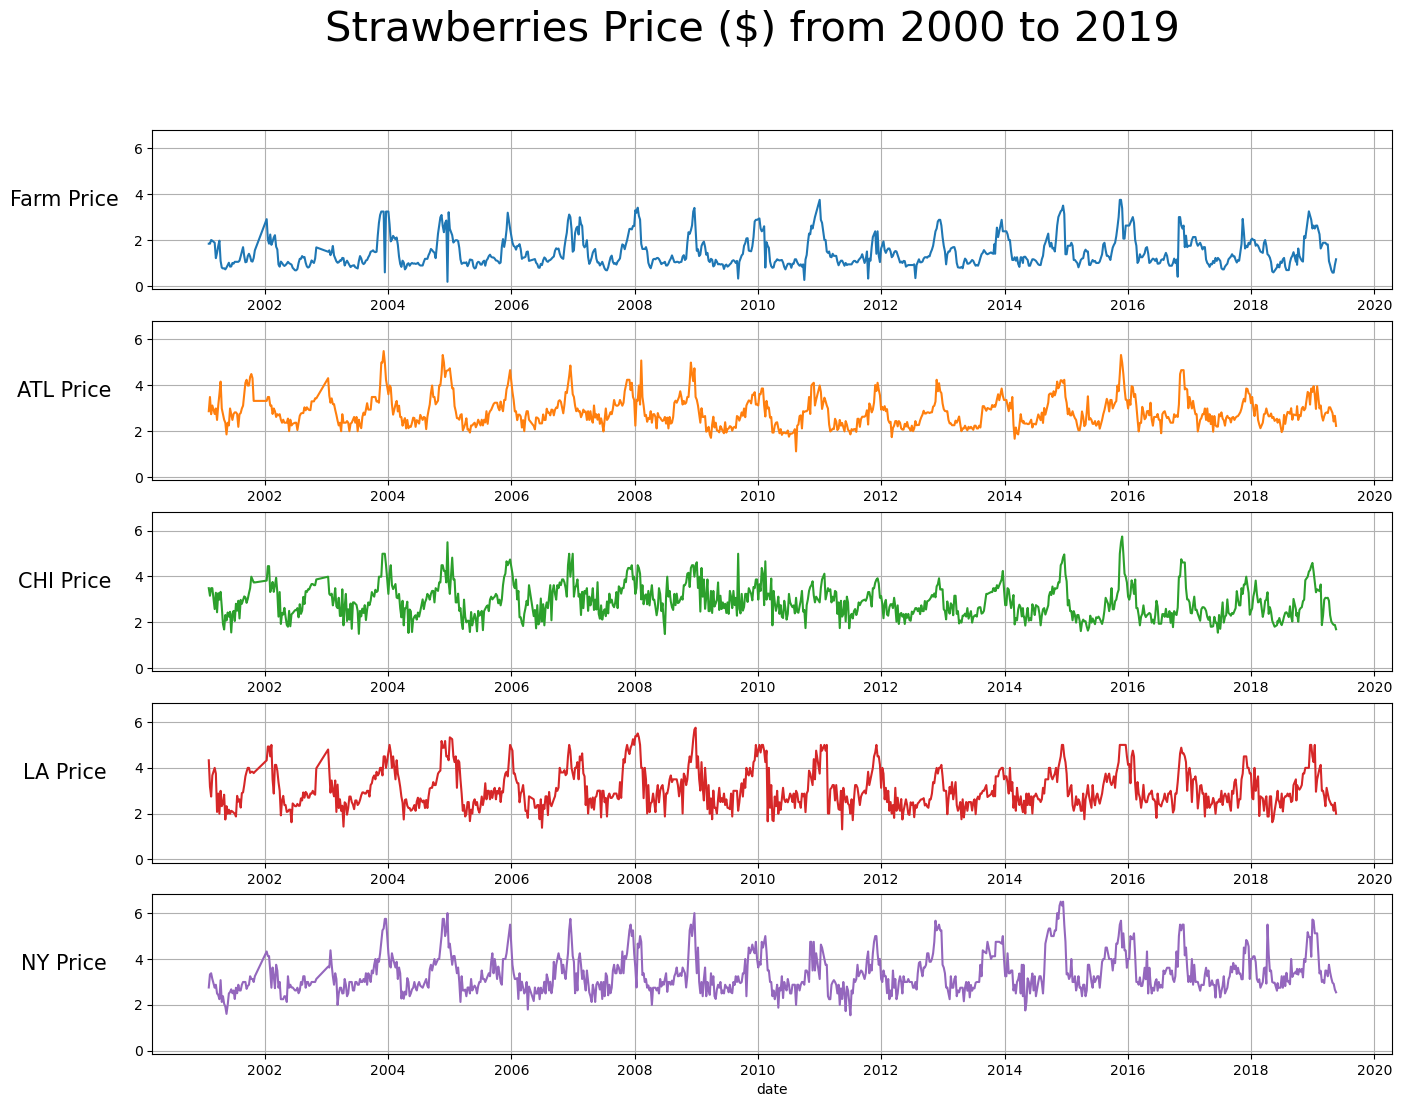

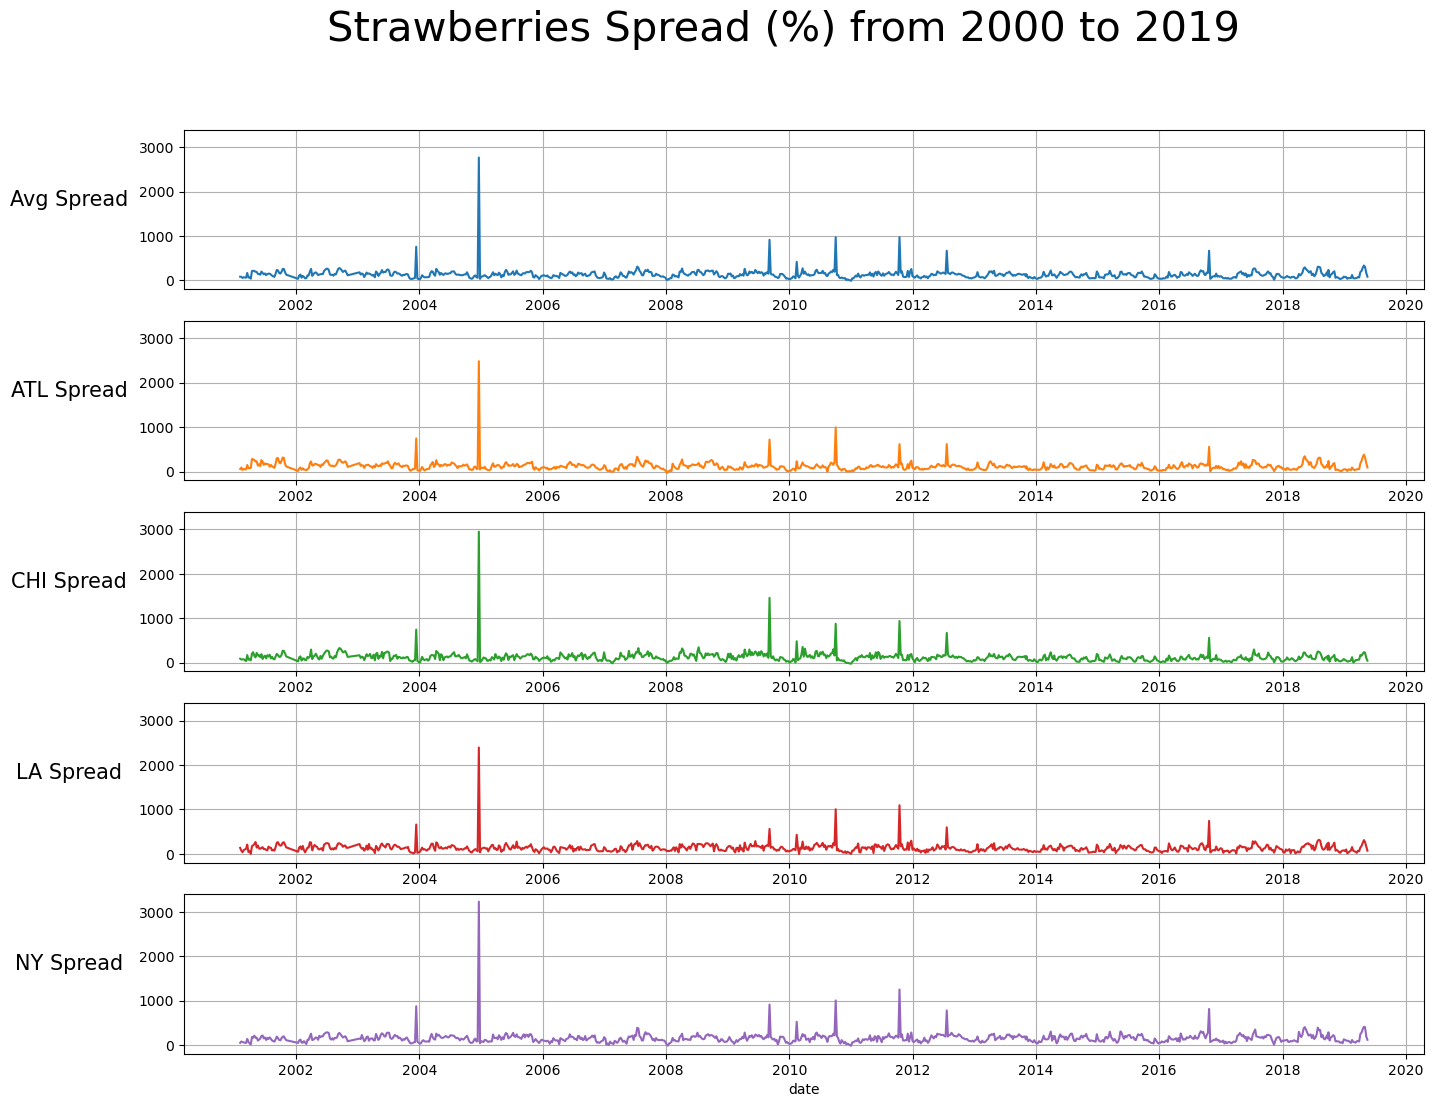

In [169]:
# Identify time periods of spikes for 'Honeydews', 'Strawberries', and 'Romaine Lettuce'
product='Strawberries'
gen_product_timeseries(product, start_year=2000, end_year=2019)
gen_product_timeseries(product, start_year=2000, end_year=2019, price=False)

In [238]:
# Paired T-test to determine if prices between cities are materialy different
import scipy.stats as stats

def paired_ttest_city(city_1='la', city_2='ny', alt='two-sided', plot=True):
    # Set string variable based on price bool variable
#     if price:
#         append = 'price'
#         unit = '$'
#     else:
#         append = 'spread'
#         unit = '%'
     
    # Create scatter plot of selected data if plot=True
    if plot:
        sns.scatterplot(data=df, x=f"{city_1.lower()}_price", y=f"{city_2.lower()}_price", hue='product_name')
        plt.title(f"{city_1.upper()} vs. {city_2.upper()} Price ($)")
        plt.xlabel(city_1.upper())
        plt.ylabel(city_2.upper())
        plt.legend(title='Product', ncols=2, bbox_to_anchor=(1,1))
        plt.show()
    
    # Run T-Test
    t_stat, p_value = stats.ttest_rel(df[f"{city_1.lower()}_price"], df[f"{city_2.lower()}_price"], alternative=alt)
    
    print(f"Paired T-Test for {city_1.upper()} and {city_2.upper()} Prices ({alt})")
    print("-"*50)
    if alt=='two-sided':
        print("Null Hypothesis: Average prices in the two cities are equal")
        print("Alternative Hypothesis: Average prices in the two cities are not equal")
    elif alt=='less':
        print(f"Null Hypothesis: {city_1.upper()} has greater or equal average prices than {city_2.upper()}")
        print(f"Alternative Hypothesis: {city_1.upper()} has lower average prices than {city_2.upper()}")
    else:
        print(f"Null Hypothesis: {city_1.upper()} has lower or equal average prices than {city_2.upper()}")
        print(f"Alternative Hypothesis: {city_1.upper()} has greater average prices than {city_2.upper()}")  
    print("-"*50)
    print("DATA")
    print(f"{city_1.upper()} Mean: {df[f'{city_1.lower()}_price'].mean()}")
    print(f"{city_1.upper()} Standard Deviation: {df[f'{city_1.lower()}_price'].std()}")
    print(f"{city_2.upper()} Mean: {df[f'{city_2.lower()}_price'].mean()}")
    print(f"{city_2.upper()} Standard Deviation: {df[f'{city_2.lower()}_price'].std()}")
    print("-"*50)
    print("RESULTS")
    print("Test Statistic: {:0.2f}".format(t_stat))
    print("P-Value: {:0.2f}".format(p_value))
    print("-"*50)
    print("INTERPRETATION")
    if p_value >= 0.05:
        print("Not enough statistical evidence to reject the Null Hypothesis.")
    else:
        print("There is statistical evidence to reject the Null Hypothesis and accept the Alternative Hypothesis.")

In [239]:
paired_ttest_city('chi', 'ny', alt='less', plot=False)

Paired T-Test for CHI and NY Prices (less)
--------------------------------------------------
Null Hypothesis: CHI has greater or equal average prices than NY
Alternative Hypothesis: CHI has lower average prices than NY
--------------------------------------------------
DATA
CHI Mean: 1.8214108614496376
CHI Standard Deviation: 0.8453684767015799
NY Mean: 2.0632570261324354
NY Standard Deviation: 1.0535813146509174
--------------------------------------------------
RESULTS
Test Statistic: -54.80
P-Value: 0.00
--------------------------------------------------
INTERPRETATION
There is statistical evidence to reject the Null Hypothesis and accept the Alternative Hypothesis.
